<a href="https://colab.research.google.com/github/neelkanthrawat/QBM_sept2022/blob/neel_kl/qmcmc_codes/mcmc_cl_and_quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [ ]:
!pip install qiskit ipywidgets # while working on google colab!

In [3]:
# while working on google colab, run this cell
!wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qmcmc_codes/qbm_utils_2.py

--2022-11-24 07:39:45--  https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qmcmc_codes/qbm_utils_2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29433 (29K) [text/plain]
Saving to: ‘qbm_utils_2.py’

qbm_utils_2.py      100%[===================>]  28.74K  --.-KB/s    in 0.002s  

2022-11-24 07:39:45 (12.9 MB/s) - ‘qbm_utils_2.py’ saved [29433/29433]



In [4]:
from qbm_utils_2 import *

### Define the model

In [241]:
# define the model
np.random.seed(6)# should always be in the same cell!  
n_spins = 10

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

# defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.randn(n_spins,n_spins), decimals=2)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
# print("J before:"); print(J)
J= J - np.diag(np.diag(J))

# J=np.array([[0,1,0.5,-1],[1,0,0.3,0.5],[0.5,0.3,0,1],[-1,0.5,1,0]])
print("J after:", J)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))
# h=np.array([0.5]*n_spins)
print("h is:", h)

# instantiate the model
model = IsingEnergyFunction(J, h)
# print(model.get_energy('0100'))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )
print("alpha: ", alpha)

J after: [[ 0.     1.68   0.285 -0.745 -0.55   0.635  0.78  -0.28   0.91   0.045]
 [ 1.68   0.     0.735 -0.12  -0.205  0.6   -0.34   0.14   0.86   0.11 ]
 [ 0.285  0.735  0.     0.2    0.02  -0.78   0.7    1.09  -1.155  0.025]
 [-0.745 -0.12   0.2    0.     0.535  0.19  -0.7    0.46   0.14   0.17 ]
 [-0.55  -0.205  0.02   0.535  0.    -0.92   0.83  -0.255 -0.55   0.435]
 [ 0.635  0.6   -0.78   0.19  -0.92   0.     0.32  -0.62   0.66   0.815]
 [ 0.78  -0.34   0.7   -0.7    0.83   0.32   0.    -0.53  -0.98   0.075]
 [-0.28   0.14   1.09   0.46  -0.255 -0.62  -0.53   0.    -0.54   0.785]
 [ 0.91   0.86  -1.155  0.14  -0.55   0.66  -0.98  -0.54   0.    -0.355]
 [ 0.045  0.11   0.025  0.17   0.435  0.815  0.075  0.785 -0.355  0.   ]]
h is: [-0.97  0.17  0.12 -0.68 -1.91 -0.14  0.11 -0.4  -0.95 -1.07]
alpha:  0.6255858446578941


### Get the true distribution

In [242]:
def true_boltzman_distn(n_spins:int, temp:int, model, wanna_plot=False):

    states_nbit=states(num_spins=n_spins)# arranged in ascending order in magnitude
    # Actual_probability distribution
    transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state, beta=1./temp) ) for state in states_nbit ] )
    rqd_sum=np.sum(np.array(list(transits_bltz.values())))
    prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
    ### unsorted prob distribution
    bpd=dict(zip(states_nbit, prob_vals ))### dict of distn, arranged in ascending order of keys
    ### Prob distribution, sorted in descending order of prob values
    boltz_prob_distn_sorted_desc=value_sorted_dict( bpd, reverse=True )
    # plot distribution
    if wanna_plot:
        plt.figure(2)
    plot_bargraph_desc_order(boltz_prob_distn_sorted_desc, label="analytical",plot_first_few=30); plt.legend()
    
    return boltz_prob_distn_sorted_desc, bpd

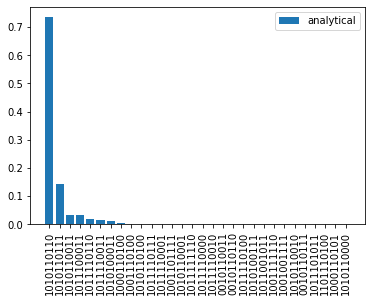

In [243]:
states_nbit=states(num_spins=n_spins)
temp=0.4
boltz_prob_distn,bpd=true_boltzman_distn(n_spins, temp=temp, model=model, wanna_plot=True)#dict sorted in vals,dict sorted in keys
# plot_histogram([bpd], legend=["analytical"])

In [245]:

mag_all_states=dict_magnetization_of_all_states(list_all_possible_states=states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=mag_all_states)
print("actual_avg_mag: ",actual_avg_mag)

actual_avg_mag:  2.311034139137276


### Function to run different number of mcmc chains for a particular problem instance

In [246]:
# SOME UPDATED FUNCTIONS
def uncommon_els_2_lists(list_1,list_2):
  return list(set(list_1).symmetric_difference(set(list_2)))

def merge_2_dict(dict1, dict2):
    return({**dict1,**dict2})

def sort_dict_by_keys(dict_in:dict):
  from collections import OrderedDict
  return dict(OrderedDict(sorted(dict_in.items())))

# some changes in clasical mcmc
def classical_mcmc(
    N_hops: int,
    num_spins: int,
    initial_state: str,
    num_elems: int,
    model,
    return_last_n_states=500,
    return_both=False,
    temp=1,
):
    """
    Args:
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model:
    return_last_n_states: (int) Number of states in the end of the M.Chain you want to consider for prob distn (default value is last 500)
    return_both (default=False): If set to True, in addition to dict_count_return_lst_n_states, also returns 2 lists:
                                "list_after_transition: list of states s' obtained after transition step s->s' " and
                                "list_after_acceptance_step: list of states accepted after the accepance step".
    Returns:
    Last 'dict_count_return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it!
    """
    states_obt = []
    # current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    current_state = initial_state
    print("starting with: ", current_state)
    states_obt.append(current_state)

    ## initialiiise observables
    # observable_dict = dict([ (elem, []) for elem in observables ])
    list_after_transition = []
    list_after_acceptance_step = []

    for i in tqdm(range(0, N_hops)):
        # get sprime
        s_prime = classical_transition(num_spins)
        list_after_transition.append(s_prime)
        # accept/reject s_prime
        energy_s = model.get_energy(current_state)
        energy_sprime = model.get_energy(s_prime)
        next_state = classical_loop_accepting_state(
            current_state, s_prime, energy_s, energy_sprime, temp=temp
        )
        current_state = next_state
        list_after_acceptance_step.append(current_state)
        states_obt.append(current_state)
        # WE DON;T NEED TO DO THIS! # reinitiate
        # qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)

    # returns dictionary of occurences for last "return_last_n_states" states
    ### added by neel 22-11-22
    all_possible_states_nbit=states(num_spins=num_spins)
    states_sampled=states_obt[-return_last_n_states:]
    states_not_obtained=uncommon_els_2_lists(all_possible_states_nbit, states_sampled)
    val_states_not_obtained=[0]*len(states_not_obtained)
    dict_states_not_obtained=dict(zip(states_not_obtained, val_states_not_obtained ))
    ### added by neel 22-11-22
    dict_count_return_last_n_states = merge_2_dict(dict(Counter(states_obt[-return_last_n_states:])), dict_states_not_obtained)

    if return_both:
        to_return = (
            dict_count_return_last_n_states,
            list_after_transition,
            list_after_acceptance_step,
        )
    else:
        to_return = dict_count_return_last_n_states

    return to_return

# some changes i quantum mcmc.
def quantum_enhanced_mcmc(
    N_hops: int,
    num_spins: int,
    initial_state: str,
    num_elems: int,
    model: IsingEnergyFunction,
    alpha,
    return_last_n_states=500,
    return_both=False,
    temp=1,
):
    """
    version 0.2
    Args:
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model:
    alpha:
    return_last_n_states:
    return_both:
    temp:

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it!
    """
    states_obt = []
    print("starting with: ", initial_state)

    ## initialise quantum circuit to current_state
    qc_s = initialise_qc(n_spins=num_spins, bitstring=initial_state)
    current_state = initial_state
    states_obt.append(current_state)
    ## intialise observables
    list_after_transition = []
    list_after_acceptance_step = []

    for i in tqdm(range(0, N_hops)):
        # print("i: ", i)
        # get sprime
        s_prime = run_qc_quantum_step(
            qc_initialised_to_s=qc_s, model=model, alpha=alpha, n_spins=num_spins
        )
        list_after_transition.append(s_prime)
        # accept/reject s_prime
        energy_s = model.get_energy(current_state)
        energy_sprime = model.get_energy(s_prime)
        next_state = classical_loop_accepting_state(
            current_state, s_prime, energy_s, energy_sprime, temp=temp
        )
        current_state = next_state
        list_after_acceptance_step.append(current_state)
        states_obt.append(current_state)
        ## reinitiate
        qc_s = initialise_qc(n_spins=num_spins, bitstring=current_state)

    # dict_count_return_last_n_states = Counter(
    #     states[-return_last_n_states:]
    # )  # dictionary of occurences for last "return_last_n_states" states
    ### added by neel 22-11-22
    all_possible_states_nbit=states(num_spins=num_spins)
    states_sampled=states_obt[-return_last_n_states:]
    states_not_obtained=uncommon_els_2_lists(all_possible_states_nbit, states_sampled)
    val_states_not_obtained=[0]*len(states_not_obtained)
    dict_states_not_obtained=dict(zip(states_not_obtained, val_states_not_obtained ))
    ### added by neel 22-11-22
    dict_count_return_last_n_states = merge_2_dict(dict(Counter(states_obt[-return_last_n_states:])), dict_states_not_obtained)


    if return_both:
        to_return = (
            dict_count_return_last_n_states,
            list_after_transition,
            list_after_acceptance_step,
        )
    else:
        to_return = dict_count_return_last_n_states

    return to_return

In [247]:
def run_mcmc_different_chains(num_spins:int, 
N_hops:int,num_seperate_mcmc_chains:int ,model,temp:float, 
return_last_n_states:int,return_both=False, is_quantum_mcmc=False, alpha=None ):

    num_elems=2**(num_spins)
    dict_seperate_chains_states_distn_mcmc={}
    dict_seperate_chains_sprime_mcmc={}
    dict_seperate_chains_accepted_mcmc={}
    dict_seperate_chains_counts_based_on_hamming_dist={}# we can get rid of these things
    dict_seperate_chains_energy_diff_s_and_sprime={}# for plotting histogram
    poss_states=list(range(0,num_elems))
    print(f"Whether running quantum mcmc: {is_quantum_mcmc}")
    for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
        init_state=np.random.choice(poss_states)
        poss_states.remove(init_state)# to ensure that each mcmc chain starts with a different initial state
        initial_state=f'{init_state:0{num_spins}b}'#f'{np.random.randint(0,num_elems):0{num_spins}b}'
        if is_quantum_mcmc:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                alpha,return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)
        else:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =classical_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)                                                                        
        # sorting states in descending order of values(# occurences in mcmc chains)  for keys(states) 
        dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)#dict_states_mcmc# this is where I might have to change things a little bit
        #storing in a dict
        dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
        dict_seperate_chains_sprime_mcmc[chain_num]=state_mcmc_after_trsn
        dict_seperate_chains_accepted_mcmc[chain_num]=state_mcmc_after_accept
        dict_seperate_chains_energy_diff_s_and_sprime[chain_num]=energy_difference_related_counts(num_spins, state_mcmc_after_trsn, state_mcmc_after_accept, model_in=model)
        dict_seperate_chains_counts_based_on_hamming_dist[chain_num]=hamming_dist_related_counts(num_spins, state_mcmc_after_trsn, state_mcmc_after_accept)

    return dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist


In [ ]:
# 10 seperate chains of classical mcmc for the given problem instance
N_hops=1000;num_seperate_mcmc_chains=4; return_last_n_states=N_hops
# later get rid of energy difference and hamming distance dicts.
dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist=run_mcmc_different_chains(n_spins, 
N_hops, num_seperate_mcmc_chains,
model, temp=temp, return_last_n_states=return_last_n_states,
return_both=True )

# TO DO:
get empirical distribution instead of count of occurence

In [249]:
# kl divergence
# calculate the kl divergence
from math import log2
from math import sqrt
from numpy import asarray
def kl_divergence(p:list, q:list):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)) if p[i]!=0)

# calculate the js divergence
def js_divergence(dict_p:dict, dict_q:dict):
  p=asarray(list(dict_p.values())); q=asarray(list(dict_q.values()))
  m = 0.5 * (p + q)
  #print("m is:");print(m)
  return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def running_js_divergence(list_chain_state_accepted:list, actual_boltz_distn:dict):
  num_nhops=len(list_chain_state_accepted)
  list_js_after_each_step=[]
  possible_states=list(actual_boltz_distn.keys())
  for step_num in range(1,num_nhops):
    #print("step_num: ",step_num)
    #temp_distn_model=get_distn(list_chain_state_accepted[:step_num])
    ### added by me today:
    # 1. get list of unique elements in list_chain_state_accepted
    # 2. get list of allowed state not present in list_chain_state_accepted (list_states_not_present)
    # 3. create a temp_distn_model= 
    unique_els_list_of_accept_states=list(np.unique(list_chain_state_accepted[:step_num]))
    list_states_not_present=uncommon_els_2_lists(unique_els_list_of_accept_states,
                                                 possible_states)
    dict_states_not_obtained=dict(zip(list_states_not_present, [0]*len(list_states_not_present) ))
    temp_distn_model=merge_2_dict(get_distn(list_chain_state_accepted[:step_num]),dict_states_not_obtained)
    temp_distn_model=sort_dict_by_keys(temp_distn_model)#arranged in ascedning order of keys
  #   #Merge(get_distn(list_chain_state_accepted[:step_num]), dict(zip()))
    # print("temp_distribution:")
    # print(temp_distn_model)
    # print(f"len(temp_distn_model):{len(temp_distn_model)}")
    
    #js divergence
    js_temp=js_divergence(actual_boltz_distn,temp_distn_model)
    list_js_after_each_step.append(js_temp)
    #print(f"at step={step_num} of MCMC , KL Divergence: {js_temp}")
  return list_js_after_each_step

In [ ]:
list_running_js=[]
for i in range(0,num_seperate_mcmc_chains):# need to make this fast! it running very slowly rn
  print("i:",i)
  chain_accepted_state=dict_seperate_chains_accepted_mcmc[i]
  running_js=running_js_divergence(chain_accepted_state,bpd)
  list_running_js.append(running_js)
  plt.figure()
  plt.plot(np.sqrt(running_js))
  plt.xlabel("mcmc steps")
  plt.ylabel("J-S Distance")

In [251]:
def plot_mean_running_avg(list_of_list:list, label:str):
  mean_running_val=np.mean(list_of_list,axis=0)
  std=np.std(list_of_list,axis=0)
  plt.fill_between(range(len(mean_running_val)), mean_running_val+std/2, mean_running_val-std/2, alpha=0.1)
  plt.plot(mean_running_val,"-",label=label, linewidth=2)

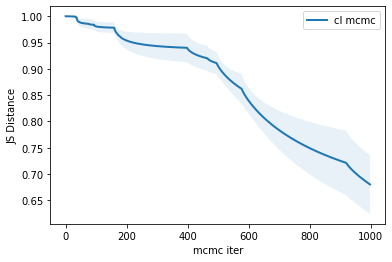

In [252]:
plot_mean_running_avg(np.sqrt(list_running_js),label="cl mcmc")
plt.xlabel("mcmc iter");plt.ylabel("JS Distance");plt.legend()

In [253]:
### data for plotting running average magnetization (averaged over "num_seperate_mcmc_chains" number of mcmc chains):
first_few=N_hops# 

list_for_df_running_avg_seperate_mcmc = []
for m in range(0, num_seperate_mcmc_chains):
    list_for_df_running_avg_seperate_mcmc.append(running_avg_magnetization_as_list(dict_seperate_chains_accepted_mcmc[m][:first_few+1]))

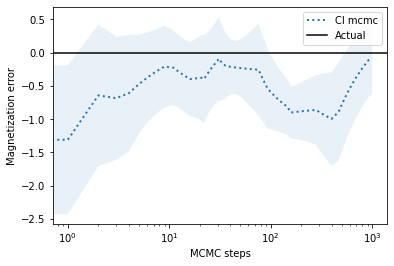

In [254]:
mean_magnetization = np.mean(list_for_df_running_avg_seperate_mcmc, axis=0) - actual_avg_mag
std_magnetization = np.std(list_for_df_running_avg_seperate_mcmc, axis=0)
plt.fill_between(range(len(mean_magnetization)), mean_magnetization+std_magnetization/2, mean_magnetization-std_magnetization/2, alpha=0.1)

plt.plot(mean_magnetization,":" ,label="Cl mcmc", linewidth=2)

plt.axhline(y=0,linestyle="-", color="k" ,label="Actual")
plt.legend()
# plt.ylim(0, 3)
plt.ylabel("Magnetization error")
plt.xlabel("MCMC steps")
plt.xscale("log")
# plt.yscale("log")
# plt.ylim(1e-2, 3)
plt.show()


In [255]:
# pandas data_frame for prob distn obtained from different mcmc chains
def fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_mcmc):
    df=pd.DataFrame(dict_seperate_chains_states_mcmc)
    df=df.fillna(0)
    return df

def get_dict_mean_occurences(df_seperate_chains_mcmc_states_occurences):
    mean_occurences=df_seperate_chains_mcmc_states_occurences.mean(axis=1)
    #print("mean occurences:"); print(mean_occurences)
    #print(f"type(mean_occurences): {type(mean_occurences)}")
    dict_mean_occurences=mean_occurences.to_dict()# mean number of occurences; we took mean of data obtained for mcmc chains
    # plt.figure(1); mean_occurences.plot.bar()
    return dict_mean_occurences

def get_empirical_distn(dict_mean_occurences):
    sum_of_counts = sum(dict_mean_occurences.values())
    empirical_probs=list(np.array(list(dict_mean_occurences.values()))/sum_of_counts)
    ### Prob distribution, sorted in descending order of prob values
    dict_empirical_prob_distn=dict(zip(list(dict_mean_occurences.keys()), empirical_probs ))
    return dict_empirical_prob_distn




<Figure size 432x288 with 0 Axes>

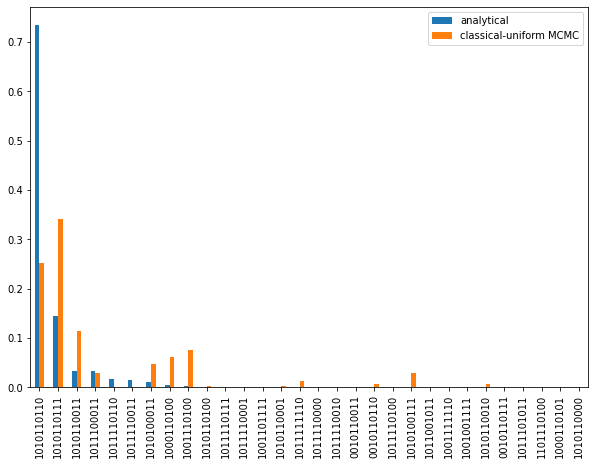

In [256]:
### for classical mcmc
df_1=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc)
dict_mean_occurences=get_dict_mean_occurences(df_1)
dict_empirical_cl_prob_distn=sort_dict_by_keys(get_empirical_distn(dict_mean_occurences))

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn],
                        list_labels=["analytical","classical-uniform MCMC"],
                        list_normalise=[False,False] ,plot_first_few=30,  
                        sort_desc=True,figsize=(10,7))

In [257]:
np.sqrt(js_divergence(bpd,dict_empirical_cl_prob_distn))

0.5015356998580848

### Quantum enhanced MCMC

In [258]:
# 10 seperate chains of quantum mcmc for the given problem instance
N_hops_q=1000;num_seperate_mcmc_chains_q=4; return_last_n_states_q=N_hops_q
dict_seperate_chains_states_distn_mcmc_q, dict_seperate_chains_sprime_mcmc_q, dict_seperate_chains_accepted_mcmc_q, dict_seperate_chains_energy_diff_s_and_sprime_q,dict_seperate_chains_counts_based_on_hamming_dist_q=run_mcmc_different_chains(n_spins, 
N_hops_q, num_seperate_mcmc_chains_q,
model, temp=temp, return_last_n_states=return_last_n_states_q,
return_both=True, is_quantum_mcmc=True, alpha=alpha )

Whether running quantum mcmc: True


  0%|          | 0/4 [00:00<?, ?it/s]

starting with:  0110111000



 25%|██▌       | 1/4 [04:00<12:00, 240.05s/it]

starting with:  0111110001



 50%|█████     | 2/4 [08:05<08:06, 243.22s/it]

starting with:  1100110110



 75%|███████▌  | 3/4 [12:12<04:04, 244.80s/it]

starting with:  1011100000



100%|██████████| 4/4 [16:26<00:00, 246.74s/it]


i: 0
i: 1
i: 2
i: 3


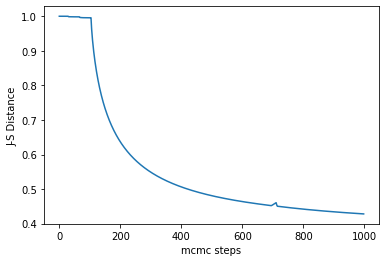

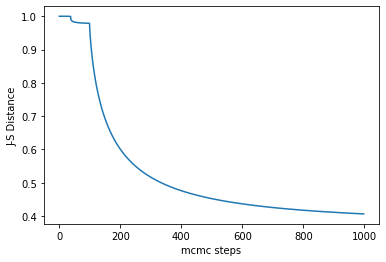

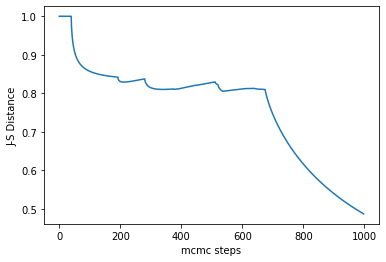

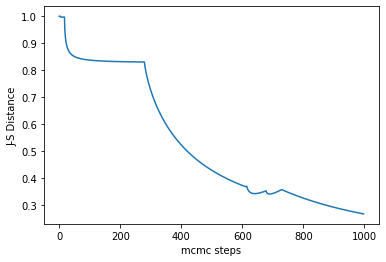

In [259]:
list_running_js_q=[]
for i in range(0,num_seperate_mcmc_chains_q):
  print("i:",i)
  chain_accepted_state_q=dict_seperate_chains_accepted_mcmc_q[i]
  running_js_q=running_js_divergence(chain_accepted_state_q,bpd)
  list_running_js_q.append(running_js_q)
  plt.figure()
  plt.plot(np.sqrt(running_js_q))
  plt.xlabel("mcmc steps")
  plt.ylabel("J-S Distance")

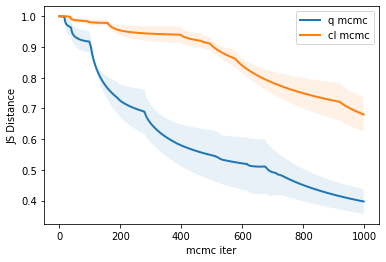

In [260]:
plot_mean_running_avg(np.sqrt(list_running_js_q),label="q mcmc")
plot_mean_running_avg(np.sqrt(list_running_js),label="cl mcmc")
plt.xlabel("mcmc iter");plt.ylabel("JS Distance");plt.legend()

In [261]:
### data for plotting running average magnetization 5 cases seperately:
first_few=N_hops_q# 
list_for_df_running_avg_seperate_mcmc_q = []
for m in range(0, num_seperate_mcmc_chains_q):
    list_for_df_running_avg_seperate_mcmc_q.append(running_avg_magnetization_as_list(dict_seperate_chains_accepted_mcmc_q[m][:first_few+1]))


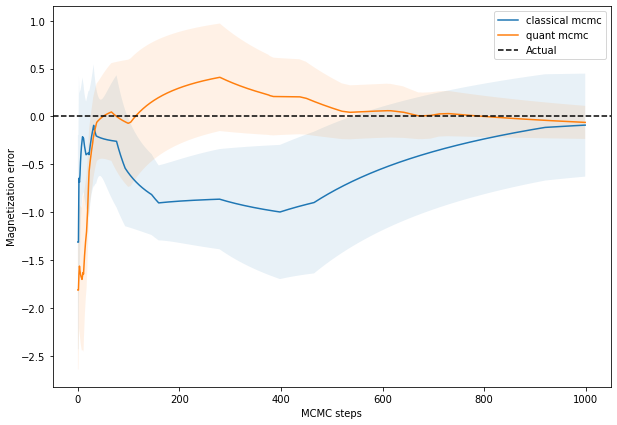

In [262]:
mean_magnetization_q = np.mean(list_for_df_running_avg_seperate_mcmc_q, axis=0) - actual_avg_mag
std_magnetization_q = np.std(list_for_df_running_avg_seperate_mcmc_q, axis=0)

plt.figure(figsize=(10,7))

plt.fill_between(range(len(mean_magnetization)), mean_magnetization+std_magnetization/2, mean_magnetization-std_magnetization/2, alpha=0.1)
plt.fill_between(range(len(mean_magnetization_q)), mean_magnetization_q+std_magnetization_q/2, mean_magnetization_q-std_magnetization_q/2, alpha=0.1)

# magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
# actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)

plt.plot(mean_magnetization,"-" ,label="classical mcmc")
plt.plot(mean_magnetization_q,"-" ,label="quant mcmc")
plt.axhline(y=0,linestyle="--", color="k" ,label="Actual")
plt.legend()
#plt.ylim(-1, 1)
plt.ylabel("Magnetization error")
plt.xlabel("MCMC steps")
plt.show()

<Figure size 432x288 with 0 Axes>

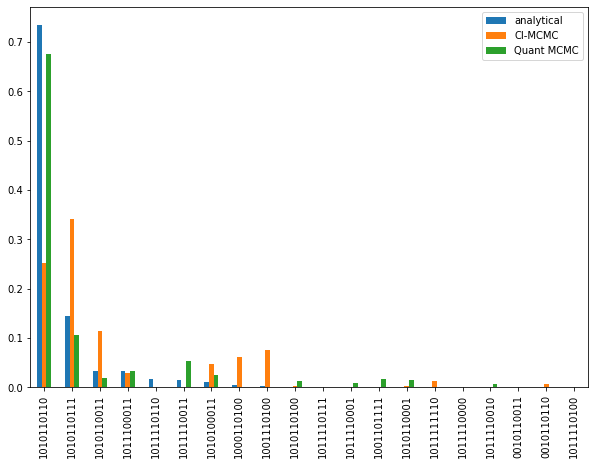

In [263]:
### for quantum mcmc
df_q=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc_q)
dict_mean_occurences_q=get_dict_mean_occurences(df_q)
dict_empirical_prob_distn_q=sort_dict_by_keys(get_empirical_distn(dict_mean_occurences_q))

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn,dict_empirical_prob_distn_q],
                        list_labels=["analytical","Cl-MCMC","Quant MCMC"],
                        list_normalise=[False,False,False] ,plot_first_few=20,  
                        sort_desc=True,figsize=(10,7))

In [264]:
print("JS distance quantum case:");
print(np.sqrt(js_divergence(dict_empirical_prob_distn_q,bpd)))
print("JS distance classical case:")
print(np.sqrt(js_divergence(dict_empirical_cl_prob_distn,bpd)))

JS distance quantum case:
0.25557841985939006
JS distance classical case:
0.5015356998580848


In [265]:
# def similarity_coefficient(target_prob_distn:dict, model_prob_distn:dict):
#   """ Returns: Bhattacharya coefficient BC(P,Q)= \sum_{i} sqrt(P(i)*Q(i))
#       Args: target_prob_distn: P
#             model_prob_distn: Q, approximates P
#   """
#   list_prob_model=list(target_prob_distn.values())
#   list_prob_data=list(model_prob_distn.values())
#   list_keys_model=list(model_prob_distn.keys())

#   sim_coeff=0
#   for i in range(0,len(list_keys_model)):
#       if(list_prob_data[i]== 0 or list_prob_model==0):
#           to_return+= 0
#       else:
#         sim_coeff+=np.sqrt(list_prob_data[i]*list_prob_model[i])
#   return sim_coeff

# def running_sim_coeff(list_chain_state_accepted:list,actual_boltz_distn:dict):
#   num_nhops=len(list_chain_state_accepted)
#   list_sim_coeff_after_each_step=[]
#   for step_num in range(1,num_nhops):
#     #print("step_num: ",step_num)
#     temp_distn_model=get_distn(list_chain_state_accepted[:step_num])
#     #print("temp_distribution:")
#     #print(temp_distn_model)
#     sim_coeff_temp=similarity_coefficient(actual_boltz_distn,temp_distn_model)
#     list_sim_coeff_after_each_step.append(sim_coeff_temp)
#     print(f"at step={step_num} of MCMC , bhatt.coeff: {sim_coeff_temp}")
#   return list_sim_coeff_after_each_step